# **Min-Wo : Chatbot Desa Wonorejo**

Min-Wo merupakan fitur chatbot yang merupakan karya di masa Kuliah Kerja Nyata (KKN) saya untuk desa Wonorejo, Sukoharjo. Dalam rangka meningkatkan ketersediaan akses informasi mengenai desa, baik dalam hal administratif, non-administratif, maupun informasi umum, dibutuhkan adanya suatu terobosan untuk memaksimalkan ketersediaan akses informasi agar mudah didapat dan diakses dimana saja oleh masyarakat Desa Wonorejo. Chatbot Sistem Aplikasi Desa hadir
sebagai solusi ketersediaan informasi berbasis digital yang enerapkan teknologi kecerdasan buatan (AI) yang mampu melakukan pertukaran informasi dari pengguna dengan sistem secara otomatis sebagai implementasi Desa Digital menuju pemerintahan pintar. Pembuatan aplikasi ini bertujuan untuk mempermudah akses informasi mengenai Desa Wonorejo untuk masyarakat lokal maupun masyarakat di luar Desa Wonorejo.

Chatbot Sistem Aplikasi Desa dibuat dengan tujuan untuk memudahkan akses informasi Desa Wonorejo baik dalam hal administratif, non-administratif, maupun informasi umum. Fitur chatbot ini mampu melakukan pertukaran informasi mengenai informasi umum Desa, informasi pengurusan dokumen / surat, informasi administratif, maupun non-administratif dari Desa Wonorejo.

Model chatbot ini kemudian diserahkan kepada pihak desa dan kelompok KKN selanjutnya untuk keperluan pengembangan lebih lanjut ataupun proses deployment ke website desa ataupun sistem chatbot di aplikasi whatsapp

## Import Library dan Package

Bagian ini berisi proses import library dan package yang dibutuhkan untuk membangun chatbot. Setelah diimport, library dan package ini dapat digunakan untuk melakukan berbagai tugas, seperti memproses data, membangun model, dan melatih model chatbot.

### **Import Library**

In [1]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

### **Download NLTK Package**

In [2]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## **Load Dataset**

Dataset yang digunakan untuk pembuatan chatbot didapat melalui proses wawancara kepada Kepala Desa Wonorejo, dan beberapa warga desa. Data yang diperoleh dari wawancara kemudian dibuat dalam format JSON yang kemudian digunakan untuk pembuatan chatbot.

In [3]:
# Importing the dataset
with open('datasets.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [4]:
data # Mencetak lima baris data paling awal dan paling akhir

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting
...,...,...
78,Siapa nama kepala desa di Desa Wonorejo?,nama_kepala_desa
79,Bagaimana persebaran agama di Desa Wonorejo?,persebaran_agama_desa
80,Apa saja agama di Desa Wonorejo?,persebaran_agama_desa
81,Siapa yang mendirikan desa Wonorejo?,pendiri_desa_wonorejo


## **Data Preprocessing**



Untuk proses pertama, data teks yang berupa kalimat atau pertanyaan dari pengguna (input) dibersihkan dari tanda baca dan diubah menjadi huruf kecil dengan tujuam untuk menyeragamkan data dan mengurangi kompleksitas.

In [5]:
# Menghilangkan Punktuasi
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))
data

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting
...,...,...
78,siapa nama kepala desa di desa wonorejo,nama_kepala_desa
79,bagaimana persebaran agama di desa wonorejo,persebaran_agama_desa
80,apa saja agama di desa wonorejo,persebaran_agama_desa
81,siapa yang mendirikan desa wonorejo,pendiri_desa_wonorejo


Selanjutnya, untuk tahap kedua dilakukan lematisasi. Proses ini bertujuan untuk mengubah kata-kata dalam data menjadi bentuk dasarnya (kata dasar). Proses ini membantu dalam mengurangi redundansi dan meningkatkan akurasi model.

In [6]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

120 unique lemmatized words ['ada', 'adakah', 'administrasi', 'afternoon', 'agama', 'apa', 'apakah', 'asal', 'aspirasi', 'awal', 'badan', 'bagaimana', 'bai', 'banyak', 'berapa', 'bro', 'bumdes', 'bye', 'byee', 'ciri', 'contoh', 'dadah', 'dah', 'dalam', 'dapat', 'desa', 'di', 'dibutuhkan', 'didirikan', 'dikunjungi', 'dokumen', 'dusun', 'event', 'good', 'hai', 'hallo', 'halo', 'hei', 'hi', 'hy', 'ikonik', 'ini', 'itu', 'jumlah', 'jumpa', 'karang', 'kasih', 'kawan', 'kepadatan', 'kepala', 'kepemudaan', 'kependudukan', 'ketua', 'khas', 'kk', 'makasih', 'malam', 'mekanisme', 'memiliki', 'mendapat', 'mendirikan', 'menjabat', 'menjadi', 'milik', 'morning', 'mudah', 'mula', 'nama', 'oleh', 'organisasi', 'pagi', 'pelaporan', 'pelaporan/aspirasi', 'pelatihan', 'pelayanan', 'pembangunan', 'pemerintahan', 'pemilihan', 'pendataan', 'penduduk', 'pengantar', 'penyampaian', 'perangkat', 'persebaran', 'prose', 'rt', 'rutin', 'rw', 'saat', 'saja', 'sampai', 'sebutan', 'see', 'selamat', 'si', 'siang', 's

In [7]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

34 classes ['administrasi_kependudukan_desa', 'administrasi_pembangunan_desa', 'administrasi_umum_desa', 'asal_mula_desa', 'asal_nama_desa', 'bumdes_wonorejo', 'ciri_khas_desa', 'dusun_desa_wonorejo', 'event_unggulan_desa', 'goodbye', 'greeting', 'karang_taruna_desa', 'kepadatan_penduduk_desa', 'lapor_aspirasi_desa', 'mekanisme_pemilihan_perangkat_desa', 'mekanisme_pemilihan_rt', 'mekanisme_pemilihan_rw', 'mekanisme_pilkades', 'nama_kepala_desa', 'pelatihan_desa', 'pendataan_umkm_desa', 'pendiri_desa_wonorejo', 'penjelasan_desa_wonorejo', 'persebaran_agama_desa', 'rt_desa_wonorejo', 'rw_desa_wonorejo', 'sebutan_desa_wonorejo', 'sistem_pelayanan_desa', 'struktur_pemerintahan_desa', 'surat_pengantar_kades', 'tempat_ikonik_desa', 'tempat_wisata_desa', 'terimakasih', 'umkm_bumdes_wonorejo']


In [8]:
print (len(documents), "documents")

441 documents


Prosesnya kemudian dilanjutkan pada Tokenisasi. Pada tahap ini, data  teks dipecah menjadi unit-unit yang lebih kecil yang disebut token. Token bisa berupa kata, frasa, atau karakter. Tokenisasi membantu dalam mengubah teks menjadi representasi numerik yang dapat diproses dengan machine learning.

In [9]:
# Tokenisasi Data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])

Tahap selanjutnya adalah padding dan label encoding. Padding digunakan untuk menyeragamkan panjang kalimat dengan menambahkan token khusus (misalnya, 0) di awal atau akhir kalimat, dan Label Encoding digunakan untuk mengubah label pada data menjadi bentuk numerik.

In [10]:
# Berikan padding
x_train = pad_sequences(train)

# Terapkan encoding
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [11]:
print(x_train) # Padding Sequences

[[  0   0   0 ...   0   0  57]
 [  0   0   0 ...   0   0  58]
 [  0   0   0 ...   0   0  59]
 ...
 [  0   0   0 ...   3   1   2]
 [  0   0   0 ... 119   1   2]
 [  0   0   0 ... 120  54  18]]


In [12]:
print(y_train) #Label Encodings

[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10  9  9  9  9  9  9  9  9  9
 32 32 32 32 32 22  4  4  3  3  6  6  8  8 26 26 27 27 27  7  7 24 25 30
 30  2  0  1 28 29 19 19 13 13 13 31 31 12 12 12 17 14 15 16  5  5  5 33
 33 20 11 11 11 18 18 23 23 21 21]


## **Input Length, Output Length and Vocabulary**



Input length mengacu pada panjang maksimum dari urutan input yang akan diproses model ML. Input length ditentukan berdasarkan panjang kalimat setelah proses tokenisasi dan padding

In [13]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

13


Vocabulary adalah kumpulan semua kata unik yang ada dalam dataset. Sedangkan output length mengacu pada umlah kelas atau label yang mungkin diprediksi oleh model yang jumlahnya sama dengan tag atau kategori pertanyaan yang berbeda

In [14]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  120
output length:  34


## **Save Model Words & Classes**

Simpan daftar vocabulary dan daftar kelas yang telah diproses sebelumnya agar dapat digunakan kembali di kemudian hari tanpa perlu melakukan preprocessing ulang

In [15]:
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))

## **Membangun Neural Network Model**

Memasuki proses ini dibangun arsitektur  dan mengonfigurasi model neural network yang akan digunakan untuk melatih chatbot. Model ini akan mempelajari pola dari data teks dan label yang telah diproses sebelumnya untuk dapat memprediksi respon yang sesuai dengan input pengguna.

In [16]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

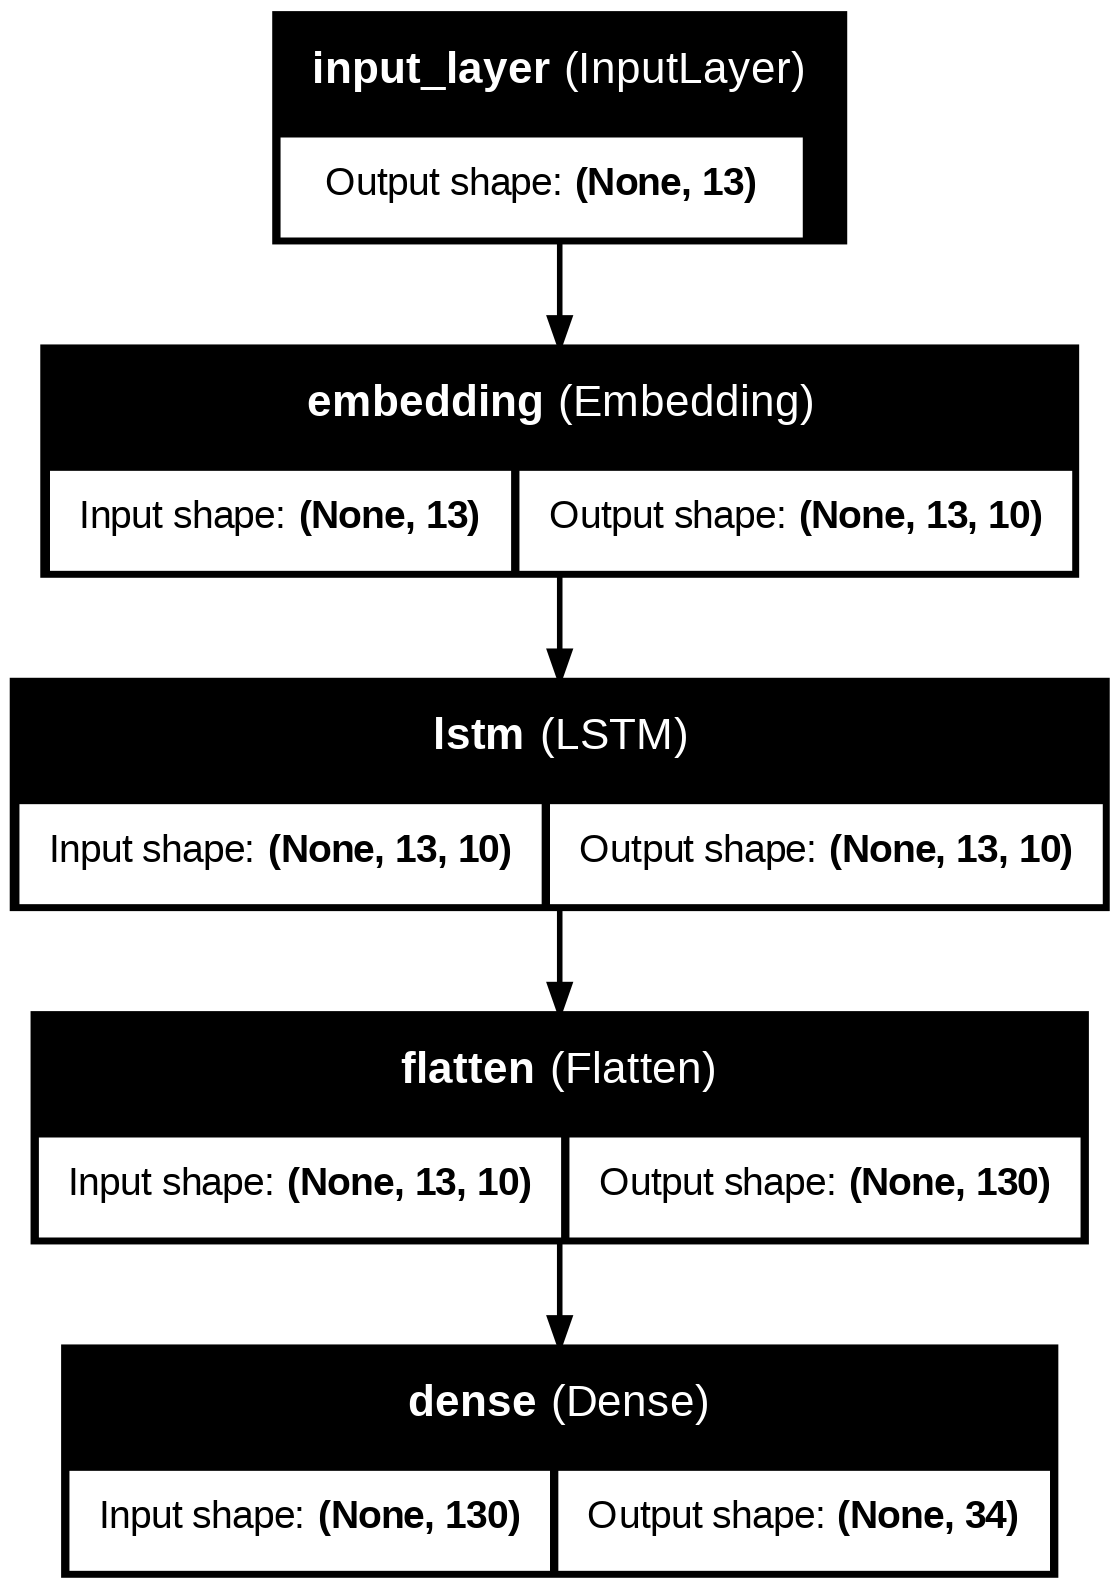

In [17]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [18]:
model.summary() # Menampilkan Parameter Model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 13)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 13, 10)              │           1,210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 13, 10)              │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 130)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 34)                  │           4,454 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,504 (25.41 KB)

 Trainable params: 6,504 (25.41 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Training the model (Latih Model Data)
train = model.fit(x_train, y_train, epochs=400)

Epoch 1/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.0181 - loss: 3.5277  
Epoch 2/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1685 - loss: 3.5171 
Epoch 3/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1997 - loss: 3.5071 
Epoch 4/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1841 - loss: 3.4922 
Epoch 5/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1529 - loss: 3.4839 
Epoch 6/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1607 - loss: 3.4597
Epoch 7/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1997 - loss: 3.4164 
Epoch 8/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2154 - loss: 3.3703  
Epoch 9/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2036 - loss: 3.3210 
Epoch 10/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1997 - loss: 3.2592
Epoch 11/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1880 - loss: 3.2283  
Epoch 12/400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1919

## **Analisis Model**

Proses analisis model dilakukan untuk menganalisis performa model neural network yang telah dilatih. Analisis ini dilakukan dengan memvisualisasikan metrik-metrik seperti akurasi dan loss selama proses pelatihan.

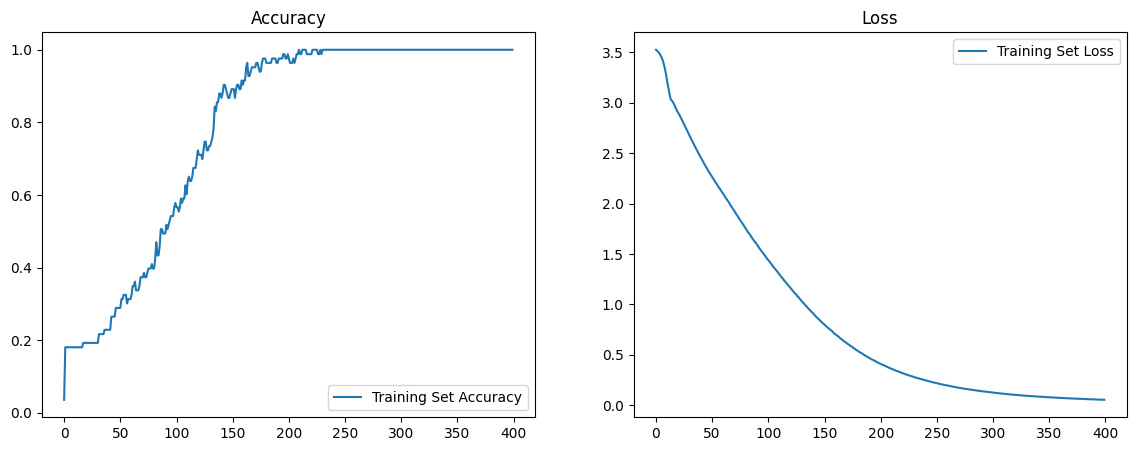

In [20]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

Kedua grafik diatas mempresentasikan grafik akurasi dan grafik loss. Grafik akurasi menunjukan bagaimana akurasi model berubah selama proses pelatihan dengan sumbu X merepresentasikan epoch dan sumbu Y mempresentasikan nilai akurasi dengan range 0 hingga 1 (atau 0% hingga 100%).

Grafik Loss menunjukkan bagaimana loss (ukuran kesalahan prediksi model) model berubah selama proses pelatihan dengan sumbu X merepresentasikan epoch dan sumbu Y mempresentasikan nilai loss.

Dengan menganalisis kedua grafik tersebut, model chatbot yang dibuat menunjukkan tren akurasi yang meningkat seiring bertambahnya epoch yang berarti model semakin baik dalam mempelajari pola dari data, dan akurasi yang tinggi (mendekati 1) menunjukkan model memiliki performa yang baik dalam memprediksi label yang benar. Sedangkan untuk grafik loss, model menunjukkan nilai loss yang semakin rendah seiring bertambahnya epoch model semakin baik dalam mengurangi kesalahan prediksi.

## **Testing Chatbot**

Testing chatbot ini dilakukan untuk memastikan fungsionalitas, identifikasi akurasi dan kesalahan, serta meningkatkan pengalaman pengguna

In [22]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('Anda : ')

  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("Min-Wo : ", random.choice(responses[response_tag]))
  time.sleep(0.08)
  print("="*60 + "\n")
  if response_tag == "goodbye":
    break

Anda : Halo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Min-Wo :  Hai! Min-Wo di sini. Mau tau informasi tentang apa nih?

Anda : apa itu desa wonorejo?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Min-Wo :  Desa Wonorejo merupakan desa yang berada di wilayah kecamatan Polokarto, kabupaten Sukoharjo, Jawa Tengah

Anda : apa yang menjadi ciri khas desa wonorejo?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Min-Wo :  Desa Wonorejo memiliki ciri khas sebagai desa religius, desa budaya, desa wisata konveksi, dan desa kuliner.

Anda : apakah desa wonorejo memiliki event unggulan?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Min-Wo :  Desa Wonorejo memiliki event unggulan, diantaranya Wonorejo Cup (turnamen sepak bola) yang diadakan setiap tahun, dan HUT Desa Wonorejo yang dilaksanakan setiap bulan Oktober.

Anda : bagaimana sistem pelayanan desa wonorejo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Min-Wo :  Desa Wonorejo memiliki sistem pelayanan desa yang mudah, dimana masyarakat dapat mengajukan permohonan pelayanan desa

## **Simpan Model**

In [23]:
model.save('chatbot_model.h5')

print('Model Created Successfully!')

Model Created Successfully!


In [ ]:
!pip install tensorflowjs

In [25]:
!tensorflowjs_converter --input_format keras chatbot_model.h5 tfjs_model

2025-01-17 05:56:08.140346: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737093368.160394    8628 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737093368.166554    8628 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file
